✍  В предыдущих юнитах мы рассмотрели отдельные модели для построения рекомендательных систем. Иногда эти модели используются вместе — такой способ построения рекомендательной системы называется **гибридным**.

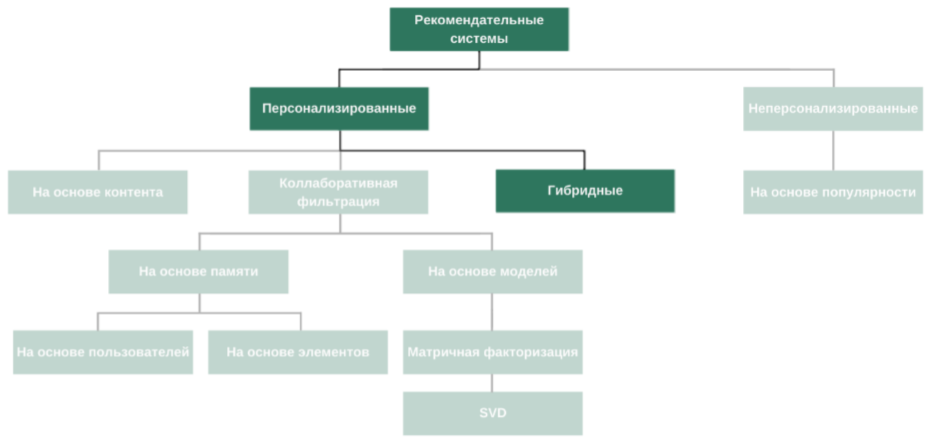

## **Гибридная РС** — это особый тип рекомендательной системы, который представляет собой комбинацию из нескольких методов. Обычно это комбинация контентного подхода и коллаборативной фильтрации. Такое сочетание может помочь преодолеть недостатки, с которыми мы сталкиваемся при использовании этих методов по отдельности, а также в некоторых случаях может быть более эффективным.

Гибридные подходы к рекомендательным системам можно реализовать по-разному, например используя комбинацию из рекомендаций, полученных обеими системами, или используя взвешенную сумму предсказанных рейтингов.

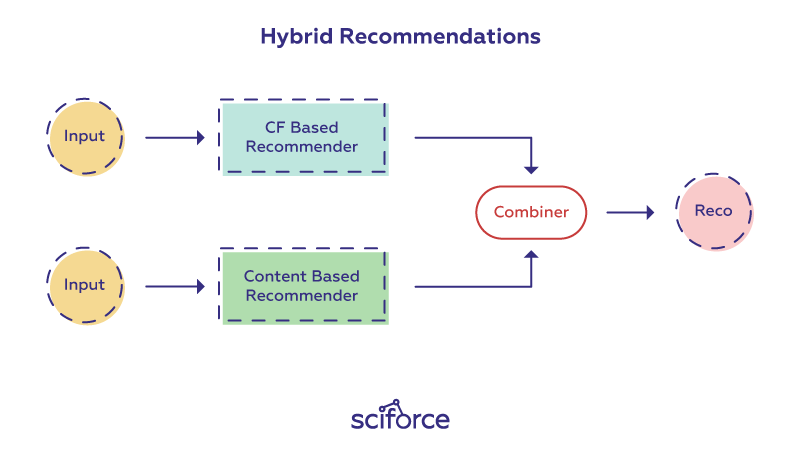

Давайте на практике рассмотрим, как создать рекомендательную систему с помощью гибридного подхода.

Разумеется, можно комбинировать различные подходы самостоятельно, однако для удобства уже реализован **модуль LightFM** — установим библиотеку через следующую команду:

In [54]:
!pip install lightfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Импортируем нужные нам функции из этой библиотеки. На этом этапе сразу же загрузим инструменты оценки модели:

In [55]:
import pandas as pd
import numpy as np

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, recall_at_k    

Работать мы будем с датасетом [goodreads_book](https://lms.skillfactory.ru/assets/courseware/v1/c977535583bf2f85a2d15617e672d8f4/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/Gooddreadbooks.zip
).

Goodreads — это сайт, на котором люди могут добавлять книги в каталоги, искать их, изучать аннотации и отзывы. Пользователи также могут создавать сообщества, в которых они рекомендуют друг другу различную литературу, ведут блоги и устраивают обсуждения.

Подгрузим все файлы, относящиеся к этому набору данных:

In [56]:
ratings = pd.read_csv('ratings.csv') # Поставленные оценки
books = pd.read_csv('books.csv') # Информация о книгах
tags = pd.read_csv('tags.csv') # Информация о тегах
book_tags = pd.read_csv('book_tags.csv') # Книги с тегами 

Сначала посмотрим на набор данных books: в этих данных есть обычный id книги, а есть id книги в системе Goodreads — этот id отображён в признаке goodreads_book_id. В других данных (book_tags) указан только id книги в системе Goodreads, поэтому нам необходимо добавить туда обычный id.

In [57]:
print("Набор данных books содержит:", books.shape[0], "строк.")
print("Набор данных ratings содержит:", ratings.shape[0], "строк.")
print("Набор данных tags содержит:", tags.shape[0], "строк.")
print("Набор данных book_tags содержит:", book_tags.shape[0], "строк.")

Набор данных books содержит: 10000 строк.
Набор данных ratings содержит: 981756 строк.
Набор данных tags содержит: 334 строк.
Набор данных book_tags содержит: 999912 строк.


## Задание 4.1

Добавьте в набор данных book_tags признак с обычным id книги, используя соответствие обычного id и id в системе Goodreads.

Какой обычный id у книги, которая имеет id 5 в системе Goodreads?

In [58]:
dict_map = dict(zip(books.goodreads_book_id,books.book_id))
book_tags['id'] = book_tags.goodreads_book_id.apply(lambda x: dict_map[x])

book_tags[book_tags['goodreads_book_id']==5]

,goodreads_book_id,tag_id,count,id
300,5,11557,40087,18
301,5,11305,39330,18
302,5,8717,17944,18
303,5,33114,12856,18
304,5,30574,11909,18
...,...,...,...,...
395,5,20781,299,18
396,5,32345,298,18
397,5,12600,282,18
398,5,3379,277,18


## Задание 4.2

Далее нам необходимо оставить в наборе данных book_tags только те записи, теги для которых есть в данных tags.

Отфильтруйте данные таким образом, чтобы в наборе данных book_tags остались только те строки, в которых находятся теги, информация о которых есть в наборе данных tags.

Сколько объектов осталось?

In [59]:
book_tags = book_tags[book_tags.tag_id.isin(tags.tag_id)]
book_tags.shape

(300738, 4)

Отлично, мы подготовили информацию о тегах книг — это будет метаинформацией для построения рекомендательной системы. Теперь нам необходимо подготовить данные о взаимодействии пользователей и книг. Для этого нам понадобится файл ratings.

Оба набора данных (и про взаимодействия, и про метаинформацию) необходимо преобразовать в разрежённые матрицы. Это можно сделать с помощью специальной функции из модуля scipy:

In [60]:
from scipy.sparse import csr_matrix

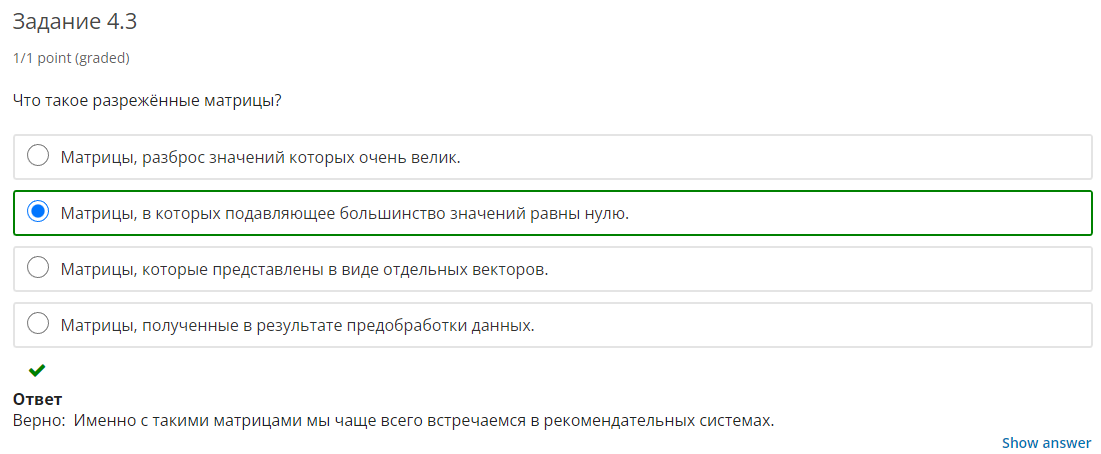

### Нам важно преобразовать данные в специальный формат, в котором хранятся разрежённые матрицы — будем использовать формат Compressed Sparse Row (CSR), подразумевающий подсчёт кумулятивной суммы количества элементов в строке вместо индексов строк.

Выглядит результат так:

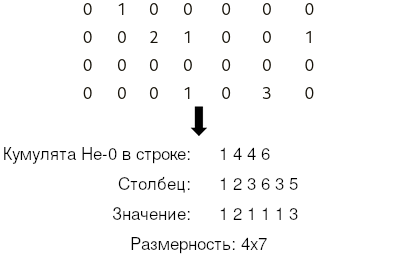

Здесь хранится информация о том, сколько суммарно ненулевых элементов в данной строке и выше, индексы столбцов с ненулевыми значениями, сами значения и размерность матрицы.

+ В первой строке обозначено, сколько накоплено ненулевых значений (в первой строке — суммарно 1, после второй строки — суммарно 4, после третьей строки — суммарно 4, после четвёртой строки — суммарно 6).
+ Во второй строке показано, в каком столбце находится ненулевое значение.
+ В третьей строке указаны сами значения.



In [61]:
# Осуществляем преобразование следующим образом:

ratings_matrix = csr_matrix((ratings.rating,(ratings.user_id,ratings.book_id))) # Передаём в качестве аргументов
#в функцию выставленный рейтинг (это будут значения матрицы), а также id пользователя и id книги (это будут индексы для строк и столбцов матрицы)

Теперь нам необходимо составить матрицу с метаданными. В качестве индексов будут выступать id книги и id тега, и если у этой книги есть рассматриваемый тег, то на пересечении соответствующих строки и столбца будет выставлена единица.



In [62]:
meta_matrix  = csr_matrix(([1]*len(book_tags),(book_tags.id,book_tags.tag_id))) 

## Задание 4.4

Давайте проверим, что всё получилось правильно.

Каково среднее арифметическое значений разрежённой матрицы с рейтингами? Ответ округлите до трёх знаков после точки-разделителя.

In [63]:
ratings_matrix.mean()

0.007086188900997592

Отлично, данные подготовлены — теперь настало время определить модель, которую мы будем использовать. Сделаем это следующим образом:

In [64]:
model = LightFM(
    loss='warp-kos', # Определяем функцию потерь
    random_state=42, # Фиксируем случайное разбиение
    learning_rate=0.05, # Темп обучения
    no_components=100 # Размерность вектора для представления данных в модели
)

В качестве функции потерь мы выбрали значение 'warp', хотя, разумеется, это не единственный вариант. В модуле LightFM представлены следующие функции потерь:

+ 'logistic' — логистическая функция. Полезна в случаях, когда есть как положительные, так и отрицательные взаимодействия, например 1 и -1.
+ 'bpr' — байесовский персонализированный рейтинг. Можно применять, когда присутствуют только положительные взаимодействия.
+ 'warp' — парный взвешенный приблизительный ранг. Используется, если необходимо повысить качество именно в верхней части списка рекомендаций.
+ 'warp-kos' — модификация warp.

Разобьём данные на обучающую и тестовую выборки:

In [71]:
train, test = random_train_test_split(
    ratings_matrix, # Общая выборка
    test_percentage=0.2, # Размер тестовой выборки
    random_state=42 # Генератор случайных чисел
)

Теперь обучим модель на наших данных о взаимодействии, также используя метаданные о книгах. Для этого воспользуемся методом fit(). В этот метод передадим обучающую выборку, признаки товаров — item_features, количество эпох обучения (сколько раз мы будем показывать модели исходный датасет, чтобы она лучше выучила данные) — epochs, а также параметр verbose для отслеживания процесса обучения:

In [72]:
model = model.fit(
    train, # Обучающая выборка
    item_features=meta_matrix, # Признаки товаров
    epochs=10, # Количество эпох
    verbose=True # Отображение обучения
)

Epoch: 100%|██████████| 10/10 [11:35<00:00, 69.59s/it]


### Обратите внимание: из-за трудоёмкости вычислений обучение модели и оценка качества могут занимать вплоть до 15-20 минут (зависит от мощности компьютера). Не волнуйтесь, это нормальная ситуация.

### Примечание. Если вы работаете через Google Collab, то для того, чтобы ускорить процесс обучения, вы можете в метод fit() передать параметр num_threads, в котором необходимо указать количество используемых потоков процессора. Задайте его значение, например, равным 6.

## Задание 4.5

Оцените качество полученной модели с помощью функции precision_at_k, передав в неё три аргумента: модель, тестовые данные и обозначение метаданных (item_features = meta_matrix).

*Примечание. Процесс расчёта метрик рекомендательной системы также является довольно затратным по времени. Для ускорения этого процесса вы можете передать параметр num_threads, чтобы указать количество потоков процессора, используемых для вычислений.*

Выведите среднее арифметическое и округлите его до двух знаков после точки-разделителя.

In [73]:
prec_score = precision_at_k(model, test, item_features = meta_matrix).mean()
print(prec_score)

0.023226766


В рекомендательных системах метрики интерпретируются иначе, чем в задачах классификации. Показатели точности РС считаются хорошими, если они находятся в районе 0.1-0.3.

У нас получился не слишком высокий, но довольно неплохой результат. Чтобы его улучшить, можно попробовать следующее:

+ Поработать над предобработкой данных, добавив в них дополнительную информацию о товарах. Также можно попробовать воспользоваться иным способом создания разреженной матрицы, например, форматом coo_matrix() или csc_matrix(), которые также входят в библиотеку scipy. Подробнее почитать о них вы можете [здесь.](https://python-school.ru/blog/sparse-matrix-scipy/)
+ Поиграться с параметрами модели LightFM — поуправлять темпом обучения (learning_rate), размерностью вектора для представления (no_components), количеством эпох обучения (epochs) и функцией потерь (loss).


Примечание. Для предсказания рейтинга нового пользователя можно воспользоваться методом predict():

`scores = model.predict(<индекс интересующего пользователя>, np.arange(n_items), user_features=new_user_feature)`

Подробнее об этом можно узнать [здесь](https://making.lyst.com/lightfm/docs/lightfm.html#lightfm.LightFM.predict).

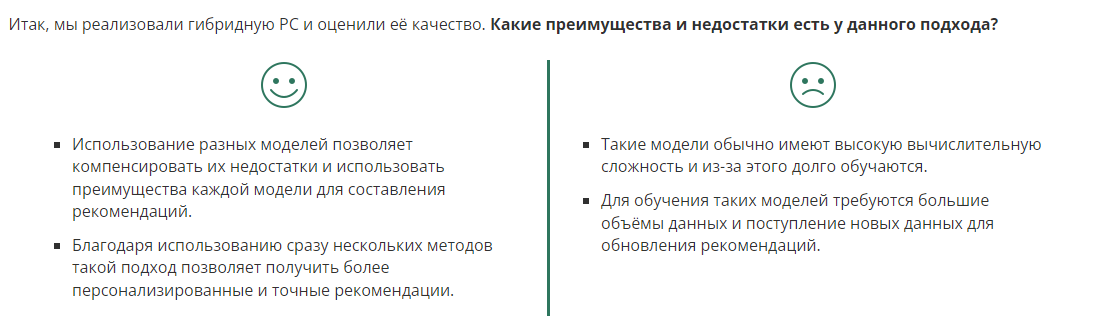

В этом юните мы обсудили, что такое гибридная рекомендательная система, и познакомились с библиотекой LightFM, с помощью которой можно обучать подобные системы. В следующем юните вас ожидает последний в этом модуле подход к построению рекомендательных систем — искусственные нейронные сети.